## Exploratory Data Analysis for 2009 - 2015 Flight Delays and Cancellations

####  Data Profiling 

##### Import required libraries

In [1]:
import findspark
findspark.init()

import pyspark
from pyspark.sql.session import SparkSession
sc = pyspark.SparkContext(appName="myAppName2").getOrCreate()
spark = SparkSession(sc)

In [2]:
from pyspark.sql.types import *
from pyspark.sql import functions as F 
from pyspark.sql.functions import isnan, when, count, col
import pandas as pd 

##### Create Schema

##### Flight Profile

##### Chunking Data

Our null analysis shows that the following features have a lot of null values: We will delete these rows, and omit some unnecessary columns as well. 

Verifying that there are no more null columns

##### Flight Cancellations

In [3]:
cancel_schema = StructType([StructField('date', StringType(), True),
                     StructField('flight_number', StringType(), True),
                     StructField('flight_identifier', StringType(), True),
                     StructField('cancel', StringType(), True),
                     StructField('reason', StringType(), True)])

In [4]:
cancel_df = spark.read.format('csv').option("mode", "DROPMALFORMED").load('flight-cancellation.csv', header='true', schema=cancel_schema) 
cancel_df = cancel_df.drop('reason')
cancel_df = cancel_df.dropna()
cancel_df = cancel_df.sample(.1)
cancel_df.printSchema()

root
 |-- date: string (nullable = true)
 |-- flight_number: string (nullable = true)
 |-- flight_identifier: string (nullable = true)
 |-- cancel: string (nullable = true)



In [5]:
cancel_df.count()

6151854

In [6]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ["date", "flight_number", "flight_identifier"]
#indexers = [StringIndexer(inputCol=column, outputCol=column + "_index").fit(cancel_df) for column in ["date", "flight_number", "flight_identifier", "cancel", "reason"]]

In [7]:
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'cancel', outputCol = 'label')
stages += [label_stringIdx]

In [8]:
assemblerInputs = [c + "classVec" for c in categoricalColumns]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [9]:
cols = ['date', 'flight_number',
 'flight_identifier',
 'cancel']

In [10]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(cancel_df)
cancel_df = pipelineModel.transform(cancel_df)
selectedCols = ['label', 'features'] + cols
cancel_df = cancel_df.select(selectedCols)
cancel_df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- date: string (nullable = true)
 |-- flight_number: string (nullable = true)
 |-- flight_identifier: string (nullable = true)
 |-- cancel: string (nullable = true)



In [11]:
cancel_df.show(5)

+-----+--------------------+----+-------------+-----------------+------+
|label|            features|date|flight_number|flight_identifier|cancel|
+-----+--------------------+----+-------------+-----------------+------+
|  0.0|(7566,[2,560,7555...|2009|         1212|               XE|     0|
|  0.0|(7566,[2,1076,755...|2009|         1236|               XE|     0|
|  0.0|(7566,[2,1494,755...|2009|         2002|               XE|     0|
|  0.0|(7566,[2,1827,755...|2009|         2010|               XE|     0|
|  0.0|(7566,[2,1629,755...|2009|         2029|               XE|     0|
+-----+--------------------+----+-------------+-----------------+------+
only showing top 5 rows



In [12]:
train, test = cancel_df.randomSplit([0.7, 0.3], seed = 2018)

In [13]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label')
lrModel = lr.fit(train)

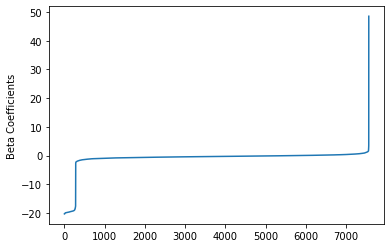

In [14]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.xlabel('Features')
plt.show()

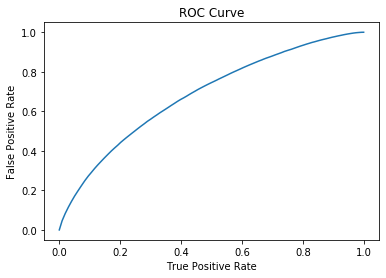

Training set area under ROC: 0.6831513490777816


In [15]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set area under ROC: ' + str(trainingSummary.areaUnderROC))

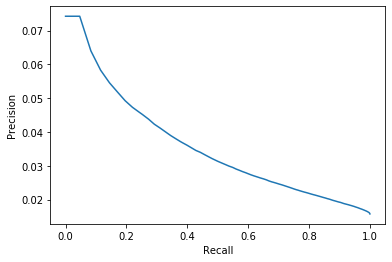

In [16]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [17]:
import matplotlib.pyplot as plt
import numpy as np

predictions = lrModel.transform(test)

predictions.select('date',
 'flight_number',
 'flight_identifier', 'prediction', 'probability').show(10)

+----+-------------+-----------------+----------+--------------------+
|date|flight_number|flight_identifier|prediction|         probability|
+----+-------------+-----------------+----------+--------------------+
|2009|           16|               WN|       0.0|[0.99108781155542...|
|2009|           16|               WN|       0.0|[0.99108781155542...|
|2009|           16|               WN|       0.0|[0.99108781155542...|
|2009|           16|               WN|       0.0|[0.99108781155542...|
|2009|           16|               WN|       0.0|[0.99108781155542...|
|2009|           16|               WN|       0.0|[0.99108781155542...|
|2009|           16|               WN|       0.0|[0.99108781155542...|
|2009|           16|               WN|       0.0|[0.99108781155542...|
|2009|           16|               WN|       0.0|[0.99108781155542...|
|2009|           16|               WN|       0.0|[0.99108781155542...|
+----+-------------+-----------------+----------+--------------------+
only s

In [18]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.6379556663210726


In [19]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('date',
 'flight_number',
 'flight_identifier', 'prediction', 'probability').show(10)

+----+-------------+-----------------+----------+--------------------+
|date|flight_number|flight_identifier|prediction|         probability|
+----+-------------+-----------------+----------+--------------------+
|2009|           16|               WN|       0.0|[0.98422426119588...|
|2009|           16|               WN|       0.0|[0.98422426119588...|
|2009|           16|               WN|       0.0|[0.98422426119588...|
|2009|           16|               WN|       0.0|[0.98422426119588...|
|2009|           16|               WN|       0.0|[0.98422426119588...|
|2009|           16|               WN|       0.0|[0.98422426119588...|
|2009|           16|               WN|       0.0|[0.98422426119588...|
|2009|           16|               WN|       0.0|[0.98422426119588...|
|2009|           16|               WN|       0.0|[0.98422426119588...|
|2009|           16|               WN|       0.0|[0.98422426119588...|
+----+-------------+-----------------+----------+--------------------+
only s

In [20]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.5


In [21]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('date',
 'flight_number',
 'flight_identifier', 'prediction', 'probability').show(10)

+----+-------------+-----------------+----------+--------------------+
|date|flight_number|flight_identifier|prediction|         probability|
+----+-------------+-----------------+----------+--------------------+
|2009|           16|               WN|       0.0|[0.98422653322642...|
|2009|           16|               WN|       0.0|[0.98422653322642...|
|2009|           16|               WN|       0.0|[0.98422653322642...|
|2009|           16|               WN|       0.0|[0.98422653322642...|
|2009|           16|               WN|       0.0|[0.98422653322642...|
|2009|           16|               WN|       0.0|[0.98422653322642...|
|2009|           16|               WN|       0.0|[0.98422653322642...|
|2009|           16|               WN|       0.0|[0.98422653322642...|
|2009|           16|               WN|       0.0|[0.98422653322642...|
|2009|           16|               WN|       0.0|[0.98422653322642...|
+----+-------------+-----------------+----------+--------------------+
only s

In [22]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.5013583107118456


In [23]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('date',
 'flight_number',
 'flight_identifier', 'prediction', 'probability').show(10)

+----+-------------+-----------------+----------+--------------------+
|date|flight_number|flight_identifier|prediction|         probability|
+----+-------------+-----------------+----------+--------------------+
|2009|           16|               WN|       0.0|[0.92820815029699...|
|2009|           16|               WN|       0.0|[0.92820815029699...|
|2009|           16|               WN|       0.0|[0.92820815029699...|
|2009|           16|               WN|       0.0|[0.92820815029699...|
|2009|           16|               WN|       0.0|[0.92820815029699...|
|2009|           16|               WN|       0.0|[0.92820815029699...|
|2009|           16|               WN|       0.0|[0.92820815029699...|
|2009|           16|               WN|       0.0|[0.92820815029699...|
|2009|           16|               WN|       0.0|[0.92820815029699...|
|2009|           16|               WN|       0.0|[0.92820815029699...|
+----+-------------+-----------------+----------+--------------------+
only s

In [24]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.6325684868166974


##### Flight Delays

In [25]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.6379975848478447

In [32]:
cvModel.bestModel

GBTClassificationModel (uid=GBTClassifier_eb9d16bec292) with 10 trees

In [34]:
cvModel.getEstimatorParamMaps()[ np.argmax(cvModel.avgMetrics) ]


{Param(parent='GBTClassifier_eb9d16bec292', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 6,
 Param(parent='GBTClassifier_eb9d16bec292', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 20}